In [1]:
import sys, os
from pathlib import Path
try:
  import google.colab
  USING_COLAB = True
except:
  USING_COLAB = False

if USING_COLAB:

  os.chdir("/content")
  os.system("git clone https://github.com/src47/multibax-sklearn.git")
  os.chdir("multibax-sklearn")
  sys.path.extend(["/content/multibax-sklearn"])
  ! pip install python-ternary
else:
  os.chdir("../../") # cell can only be run once!

In [ ]:
%load_ext autoreload
%autoreload 2

import warnings
import os 

import numpy as np
from matplotlib import pyplot as plt 
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, Matern
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from src.utils import load_ternary_data
from src.algorithms import SubsetAlgorithm
from src.plotting import plot_algo_true_function

plt.style.use("src/matplotlib.rc")
warnings.filterwarnings('ignore') 
np.random.seed(47)

## Running an algorithm on the posterior mean or posterior samples from a Gaussian Process

The catch in the analysis from [tutorial_1](tutorial_1_expressing_a_goal_as_an_algorithm.ipynb) is that of course we do not actually know f(X). We only know X -- the set of materials we can make. f(X) is expensive and time-consuming to obtain. The question is, can we perform experiments in an intelligent way to approximate the result of running the algorithm on the true function without having to do the full set of experiments. 

The answer is yes, using the technique of Bayesian Algorithm Execution. The idea is to train a Gaussian Process model to approximate f(X) using small datasets. The algorithm can be executed on the predicted f(X) rather than on the true f(X) cheaply. We can then use the information from the algorithm output to guide decision making.

Let's see how to do this. First, we reload the dataset and use the same task of multi percentile set estimation:

In [ ]:
!wget -q https://github.com/usnistgov/remi/raw/nist-pages/data/Combinatorial%20Libraries/Fe-Co-Ni/FeCoNi_benchmark_dataset_220501a.mat
!mkdir datasets
!mv FeCoNi_benchmark_dataset_220501a.mat datasets/

In [3]:
# Data loading
X, Y = load_ternary_data('datasets/FeCoNi_benchmark_dataset_220501a.mat')
n_features, n_properties = X.shape[1], Y.shape[1]

x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

scalers = [x_scaler, y_scaler]

X_norm = x_scaler.fit_transform(X)
Y_norm = y_scaler.fit_transform(Y)

# Algorithm definition
class PercentileIntersection2D(SubsetAlgorithm):
    def __init__(self, user_algo_params):
        super().__init__(user_algo_params)

    def user_algorithm(self, f_x, x):
        # percentile threshold value for property 1 
        percentile_list = self.user_algo_params['percentile_list']
        percentile_threshold_p1 = np.percentile(f_x[:, 0], percentile_list[0])

        # percentile threshold value for property 2    
        percentile_threshold_p2 = np.percentile(f_x[:, 1], percentile_list[1])

        # Determine the ids where each condition holds seperately 
        ids1 = set(np.where(f_x[:,0] >= percentile_threshold_p1)[0])
        ids2 = set(np.where(f_x[:,1] >= percentile_threshold_p2)[0])

        # Take the union to express the "either/or" logic. 
        return list(ids1.union(ids2))

Now, instead of using the full function values, let's start with a small dataset consisting of a subset of X and f(X):

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, Y_norm, test_size=0.975, random_state=42)
X_train.shape, y_train.shape

((23, 2), (23, 2))

We define a Gaussian Process model and fit it to the data. A Gaussian Process is a distribution over functions; we can obtain a posterior mean function $\bar{f}$ or sample from it to generate posterior function samples, $f_{i:n}$. Note, we use a custom class MGPR which is a simple wrapper on the sklearn GaussianProcessRegressor in order to have multiple independent GPs (one for each of $m$ measured properties). 

In [5]:
from src.models import MGPR

kernel_initial = ConstantKernel(constant_value=1.0, constant_value_bounds=[0.01, 3.0]) * Matern(nu = 5/2, length_scale= n_features * [1.0], length_scale_bounds= n_features * [[0.01, 3.0]]) + WhiteKernel(noise_level=0.01, noise_level_bounds='fixed')
kernel_initial_list = n_properties * [kernel_initial]

multi_gpr = MGPR(kernel_list=kernel_initial_list)

multi_gpr.fit(X_train, y_train)

Now that we have fitted the GP model, we can use it to predict a mean response (posterior_mean) and a predicted uncertainty (posterior_std) across the entire design space. 

In [6]:
posterior_mean, posterior_std = multi_gpr.predict(X_norm)

Now, finally, we can execute our algorithm on the posterior_mean instead of f(X). This will give us a set of points predicted (based on the posterior mean) to be the target design points. These points are shown in maroon below. Note, even with relatively limited data, there is substantial overlap between the predicted and true target points. Executing an algorithm on the posterior mean is a core idea of the MeanBAX algorithm (tutorial 3). 

<code>algorithm.identify_subspace(f_x = $\bar{f}$, x = X)</code>


In [7]:
user_algo_params = {'scalers': scalers, 'percentile_list': [90, 90]}
algorithm = PercentileIntersection2D(user_algo_params=user_algo_params)
posterior_mean_subset_ids = algorithm.identify_subspace(f_x = posterior_mean, x = X_norm)
print("predicted X: ", *X[posterior_mean_subset_ids], sep=', ')

predicted X: , [91.7  3.6], [89.7  3.6], [87.8  3.6], [85.9  3.6], [84.   3.6], [82.   3.6], [80.1  3.6], [78.2  3.6], [76.2  3.6], [43.5 44.4], [59.6 35.4], [57.6 35.4], [55.7 35.4], [53.8 35.4], [51.9 35.4], [49.9 35.4], [38.2 51.2], [58.4 37.6], [56.5 37.6], [54.6 37.6], [52.7 37.6], [50.7 37.6], [48.8 37.6], [46.9 37.6], [55.4 39.9], [53.5 39.9], [51.5 39.9], [49.6 39.9], [47.7 39.9], [45.8 39.9], [52.3 42.2], [50.4 42.2], [48.5 42.2], [46.6 42.2], [44.6 42.2], [84.4 10.4], [82.5 10.4], [80.6 10.4], [78.7 10.4], [76.7 10.4], [74.8 10.4], [72.9 10.4], [71.  10.4], [69.  10.4], [67.1 10.4], [65.2 10.4], [63.2 10.4], [61.3 10.4], [59.4 10.4], [57.5 10.4], [55.5 10.4], [53.6 10.4], [51.7 10.4], [49.7 10.4], [47.8 10.4], [45.9 10.4], [44.  10.4], [42.  10.4], [40.1 10.4], [38.2 10.4], [36.3 10.4], [34.3 10.4], [32.4 10.4], [30.5 10.4], [28.5 10.4], [26.6 10.4], [24.7 10.4], [22.8 10.4], [20.8 10.4], [18.9 10.4], [17.  10.4], [15.  10.4], [13.1 10.4], [11.2 10.4], [ 9.3 10.4], [ 7.3 10.4

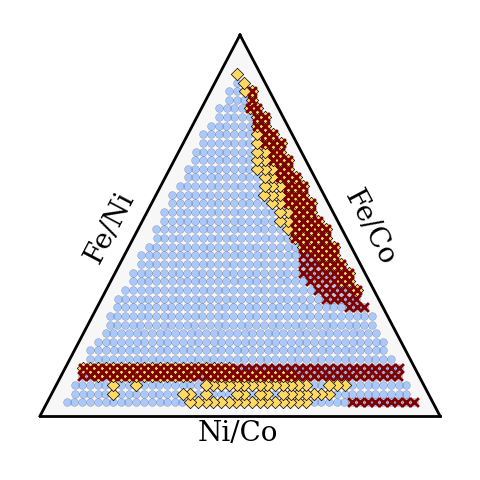

In [8]:
plot_algo_true_function(algorithm, x_scaler, y_scaler, X_norm, Y_norm, posterior_mean=posterior_mean, posterior_samples=None)

In addition to the posterior mean, we can also draw posterior samples from the GP model. Each posterior sample represents a guess over the entire domain of the values of the properties. Again, we can run our algorithm on posterior samples to get predicted target locations. In the example below, we draw 20 functions from the posterior distribution of the GP and execute our algorithm.

<code>algorithm.identify_subspace(f_x = $f_i$, x = X)</code>


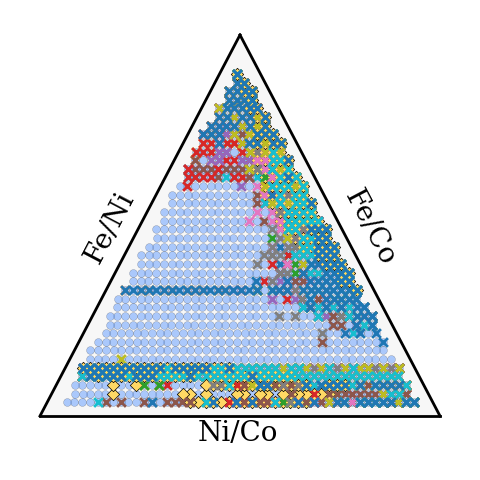

In [9]:
posterior_samples = multi_gpr.sample_y(X_norm, n_samples = 20)
plot_algo_true_function(algorithm, x_scaler, y_scaler, X_norm, Y_norm, posterior_mean=None, posterior_samples=posterior_samples)

Executing an algorithm on the posterior samples is a core idea of the InfoBAX algorithm. In [tutorial 3](tutorial_3_defining_metrics.ipynb), we will see how to quantify metrics for data acquisition quality. In [tutorial 4](tutorial_4_data_acquisition_using_BAX.ipynb), we will see how the information of algorithm execution on ML fitting models is converted in an acquisition function for efficient sampling. 
